In [1]:
!pip install pyro-ppl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 730.7/730.7 KB 41.7 MB/s eta 0:00:00


In [2]:
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import numpy as np
import random
import matplotlib.pyplot as plt
import torch.distributions as t_dist
from tqdm import tqdm
import random

import pyro
import pyro.distributions as p_dist
from pyro.infer import Importance

In [3]:
cuda2 = torch.cuda.is_available() #GPU
batch_size2 = 128
log_interval2 = 10
epochs2 = 100

torch.manual_seed(1) # args.seed

device = torch.device("cuda" if cuda2 else "cpu") # args.cuda
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda2 else {} # args.cuda

# Get train and test data
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=batch_size2, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.ToTensor()),
    batch_size=batch_size2, shuffle=True, **kwargs)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



In [4]:
# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(x, recon_x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD # -ELBO

In [5]:
def train(epoch,model):
    model.train() # so that everything has gradients and we can do backprop and so on...
    train_loss = 0
    for batch_idx, (data, _) in enumerate(tqdm(train_loader, leave=False)):
        data = data.to(device)
        optimizer.zero_grad() # "reset" gradients to 0 for text iteration
        model_output = model(data)
        loss = loss_function(data, *model_output)
        loss.backward() # calc gradients
        train_loss += loss.item()
        optimizer.step() # backpropagation

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))


def test(epoch,model):
    model.eval()
    test_loss = 0
    with torch.no_grad(): # no_grad turns of gradients...
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            model_output = model(data)
            test_loss += loss_function(data, *model_output).item()

    test_loss /= len(test_loader.dataset)
    
    print('====> Test set loss: {:.4f}'.format(test_loss))
    

## Original VAE

In [6]:
# Define VAE model
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(784, 400)
        self.fc1a = nn.Linear(400, 100)
        self.fc21 = nn.Linear(100, 2) # Latent space of 2D
        self.fc22 = nn.Linear(100, 2) # Latent space of 2D
        self.fc3 = nn.Linear(2, 100) # Latent space of 2D
        self.fc3a = nn.Linear(100, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        x = x.flatten(1)
        h1 = F.relu(self.fc1(x))
        h2 = F.relu(self.fc1a(h1))
        return self.fc21(h2), self.fc22(h2)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        h4 = F.relu(self.fc3a(h3))
        return torch.sigmoid(self.fc4(h4))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [7]:
vae = VAE().to(device)
optimizer = optim.Adam(vae.parameters(), lr=1e-3)

for epoch in range(1, epochs2 + 1):
    train(epoch,vae)
    test(epoch,vae)

====> Epoch: 1 Average loss: 186.9280


====> Test set loss: 166.6166


====> Epoch: 2 Average loss: 162.6723


====> Test set loss: 159.3494


====> Epoch: 3 Average loss: 157.3037


====> Test set loss: 155.1305


====> Epoch: 4 Average loss: 153.5890


====> Test set loss: 152.5843


====> Epoch: 5 Average loss: 151.3062


====> Test set loss: 151.0713


====> Epoch: 6 Average loss: 149.5204


====> Test set loss: 149.5301


====> Epoch: 7 Average loss: 148.2593


====> Test set loss: 148.1627


====> Epoch: 8 Average loss: 147.2703


====> Test set loss: 147.8796


====> Epoch: 9 Average loss: 146.3047


====> Test set loss: 146.9388


====> Epoch: 10 Average loss: 145.6224


====> Test set loss: 146.1947


====> Epoch: 11 Average loss: 145.2303


====> Test set loss: 147.0720


====> Epoch: 12 Average loss: 144.7898


====> Test set loss: 145.6656


====> Epoch: 13 Average loss: 144.0341


====> Test set loss: 144.6650


====> Epoch: 14 Average loss: 143.8549


====> Test set loss: 144.3968


====> Epoch: 15 Average loss: 143.2287


====> Test set loss: 144.6947


====> Epoch: 16 Average loss: 142.6329


====> Test set loss: 144.2449


====> Epoch: 17 Average loss: 142.3887


====> Test set loss: 143.9312


====> Epoch: 18 Average loss: 142.2185


====> Test set loss: 144.0647


====> Epoch: 19 Average loss: 141.7190


====> Test set loss: 143.0000


====> Epoch: 20 Average loss: 141.6437


====> Test set loss: 143.1173


====> Epoch: 21 Average loss: 141.5294


====> Test set loss: 142.5813


====> Epoch: 22 Average loss: 141.1250


====> Test set loss: 142.6621


====> Epoch: 23 Average loss: 140.7075


====> Test set loss: 142.5698


====> Epoch: 24 Average loss: 140.4602


====> Test set loss: 142.5192


====> Epoch: 25 Average loss: 140.4015


====> Test set loss: 142.1531


====> Epoch: 26 Average loss: 140.0851


====> Test set loss: 142.1819


====> Epoch: 27 Average loss: 139.8330


====> Test set loss: 141.8349


====> Epoch: 28 Average loss: 139.5305


====> Test set loss: 141.4654


====> Epoch: 29 Average loss: 139.3899


====> Test set loss: 141.7329


====> Epoch: 30 Average loss: 139.3719


====> Test set loss: 141.3997


====> Epoch: 31 Average loss: 139.2608


====> Test set loss: 141.4748


====> Epoch: 32 Average loss: 138.9288


====> Test set loss: 140.9102


====> Epoch: 33 Average loss: 138.8451


====> Test set loss: 141.5408


====> Epoch: 34 Average loss: 138.7690


====> Test set loss: 140.7999


====> Epoch: 35 Average loss: 138.5205


====> Test set loss: 140.9822


====> Epoch: 36 Average loss: 138.5095


====> Test set loss: 141.3320


====> Epoch: 37 Average loss: 138.3300


====> Test set loss: 140.6082


====> Epoch: 38 Average loss: 138.1317


====> Test set loss: 140.5994


====> Epoch: 39 Average loss: 137.9567


====> Test set loss: 140.5130


====> Epoch: 40 Average loss: 137.9127


====> Test set loss: 140.6228


====> Epoch: 41 Average loss: 137.8586


====> Test set loss: 140.4187


====> Epoch: 42 Average loss: 137.6506


====> Test set loss: 140.2779


====> Epoch: 43 Average loss: 137.8702


====> Test set loss: 140.6343


====> Epoch: 44 Average loss: 137.6880


====> Test set loss: 140.3085


====> Epoch: 45 Average loss: 137.6346


====> Test set loss: 140.4770


====> Epoch: 46 Average loss: 137.5798


====> Test set loss: 140.2824


====> Epoch: 47 Average loss: 137.3571


====> Test set loss: 140.1013


====> Epoch: 48 Average loss: 137.1980


====> Test set loss: 140.3381


====> Epoch: 49 Average loss: 137.1305


====> Test set loss: 139.8134


====> Epoch: 50 Average loss: 136.8323


====> Test set loss: 139.4639


====> Epoch: 51 Average loss: 136.9847


====> Test set loss: 139.9192


====> Epoch: 52 Average loss: 136.9255


====> Test set loss: 139.6758


====> Epoch: 53 Average loss: 136.7437


====> Test set loss: 140.0314


====> Epoch: 54 Average loss: 136.8995


====> Test set loss: 140.1645


====> Epoch: 55 Average loss: 136.7366


====> Test set loss: 139.7060


====> Epoch: 56 Average loss: 136.7205


====> Test set loss: 139.7080


====> Epoch: 57 Average loss: 136.5360


====> Test set loss: 139.3438


====> Epoch: 58 Average loss: 136.4701


====> Test set loss: 139.7185


====> Epoch: 59 Average loss: 136.6623


====> Test set loss: 139.6001


====> Epoch: 60 Average loss: 136.2513


====> Test set loss: 139.3341


====> Epoch: 61 Average loss: 136.2447


====> Test set loss: 139.4642


====> Epoch: 62 Average loss: 136.1966


====> Test set loss: 139.2164


====> Epoch: 63 Average loss: 136.0649


====> Test set loss: 140.0299


====> Epoch: 64 Average loss: 136.3017


====> Test set loss: 139.2678


====> Epoch: 65 Average loss: 135.8806


====> Test set loss: 139.0099


====> Epoch: 66 Average loss: 135.7429


====> Test set loss: 139.6716


====> Epoch: 67 Average loss: 135.9074


====> Test set loss: 139.1644


====> Epoch: 68 Average loss: 135.9542


====> Test set loss: 139.6962


====> Epoch: 69 Average loss: 135.6926


====> Test set loss: 139.2629


====> Epoch: 70 Average loss: 135.6812


====> Test set loss: 139.0435


====> Epoch: 71 Average loss: 135.5744


====> Test set loss: 139.1276


====> Epoch: 72 Average loss: 135.6857


====> Test set loss: 138.9718


====> Epoch: 73 Average loss: 135.7359


====> Test set loss: 139.3578


====> Epoch: 74 Average loss: 135.6088


====> Test set loss: 139.2055


====> Epoch: 75 Average loss: 135.2364


====> Test set loss: 139.0160


====> Epoch: 76 Average loss: 135.2111


====> Test set loss: 138.9478


====> Epoch: 77 Average loss: 135.2167


====> Test set loss: 139.1664


====> Epoch: 78 Average loss: 135.3938


====> Test set loss: 138.7107


====> Epoch: 79 Average loss: 135.2062


====> Test set loss: 138.9744


====> Epoch: 80 Average loss: 135.0605


====> Test set loss: 138.9184


====> Epoch: 81 Average loss: 135.2878


====> Test set loss: 139.1399


====> Epoch: 82 Average loss: 135.5997


====> Test set loss: 138.7727


====> Epoch: 83 Average loss: 135.2738


====> Test set loss: 138.9871


====> Epoch: 84 Average loss: 135.0726


====> Test set loss: 138.5702


====> Epoch: 85 Average loss: 134.9369


====> Test set loss: 139.4879


====> Epoch: 86 Average loss: 135.1894


====> Test set loss: 138.9531


====> Epoch: 87 Average loss: 134.9795


====> Test set loss: 139.1133


====> Epoch: 88 Average loss: 134.9388


====> Test set loss: 139.3176


====> Epoch: 89 Average loss: 134.8319


====> Test set loss: 138.9094


====> Epoch: 90 Average loss: 134.7423


====> Test set loss: 138.7852


====> Epoch: 91 Average loss: 134.8606


====> Test set loss: 139.0279


====> Epoch: 92 Average loss: 134.8816


====> Test set loss: 138.7419


====> Epoch: 93 Average loss: 134.7374


====> Test set loss: 139.1682


====> Epoch: 94 Average loss: 134.7466


====> Test set loss: 138.9054


====> Epoch: 95 Average loss: 135.0578


====> Test set loss: 138.8737


====> Epoch: 96 Average loss: 135.2702


====> Test set loss: 138.8865


====> Epoch: 97 Average loss: 134.8710


====> Test set loss: 139.1852


====> Epoch: 98 Average loss: 134.8779


====> Test set loss: 138.8497


====> Epoch: 99 Average loss: 134.9756


====> Test set loss: 138.8922


====> Epoch: 100 Average loss: 135.0955


====> Test set loss: 139.2547


In [8]:
torch.save(vae.state_dict(), './vae.pt')

## Baysian VAE

$ELBO = E_q \log p(x|z,\theta) - KL(q(z,\theta) || p(z,\theta))$

$ = E_q \log p(x|z,\theta) - KL(q(z) || p(z)) - KL(q(\theta) || p(\theta))$

where $z$ is the latent variable, $\theta$ is the model weights. They are treated in the same way. We assume they are independent. $q(z)$ is the encoder, while $q(\theta)$ is a multivariate normal distribution with diagonal covariance matrix. Same as $p(z)$, we assume $p(\theta)$ is also a normal distribution. If we assume a $p(\theta)$ is a standard normal, i.e., $\Sigma = diag(1)$, the variance will become bigger and bigger after each linear layer, which hinders the model training. Thus, we choose to assume our prior $p(\theta)$ to be $N(\theta|0, diag(\frac{1}{k}))$, where k is the input dimension (number of input features) in each layer, so we keep the variance roughly unchanged each layer. Like $KL(q(z) || p(z))$, $KL(q(\theta) || p(\theta))$ has the same close-form solution. We use closed-form solution for both KL divergence, instead of estimating them. For $E_q \log p(x|z,\theta)$, we follow the same practice in VAE, using just one sample to estimate the expectation.



In [9]:
# Define VAE model
class Baysian_VAE(nn.Module):
    def __init__(self):
        super(Baysian_VAE, self).__init__()
        input_dim = 784
        dim1 = 400
        dim2 = 100
        z_dim = 2

        self.fc1 = nn.Linear(input_dim, dim1)
        self.fc1a = nn.Linear(dim1, dim2)
        self.fc21 = nn.Linear(dim2, z_dim) # Latent space of 2D
        self.fc22 = nn.Linear(dim2, z_dim) # Latent space of 2D


        # self.fc3 = nn.ParameterDict({
        #     'w_mean' : nn.Parameter(torch.zeros(z_dim, dim2)),
        #     'w_logvar' : nn.Parameter(torch.zeros(z_dim, dim2)),
        #     'b_mean' : nn.Parameter(torch.zeros(dim2)),
        #     'b_logvar' : nn.Parameter(torch.zeros(dim2)),
        # })

        # self.fc3a = nn.ParameterDict({
        #     'w_mean' : nn.Parameter(torch.zeros(dim2, dim1)),
        #     'w_logvar' : nn.Parameter(torch.zeros(dim2, dim1)),
        #     'b_mean' : nn.Parameter(torch.zeros(dim1)),
        #     'b_logvar' : nn.Parameter(torch.zeros(dim1)),
        # })

        # self.fc4 = nn.ParameterDict({
        #     'w_mean' : nn.Parameter(torch.zeros(dim1, input_dim)),
        #     'w_logvar' : nn.Parameter(torch.zeros(dim1, input_dim)),
        #     'b_mean' : nn.Parameter(torch.zeros(input_dim)),
        #     'b_logvar' : nn.Parameter(torch.zeros(input_dim)),
        # })


        # distribution parameters of decoder's weights
        # see why to use - torch.log(torch.tensor(z_dim,)): https://pytorch.org/docs/stable/generated/torch.nn.Linear.html?highlight=linear#torch.nn.Linear
        # the inital logvar is initialized such that the variance of each weight value is 1/in_features,
        # so that the output feature value has variance of 1 no matter how big in_features is

        self.fc3 = nn.ParameterDict({
            'w_mean' : nn.Parameter(torch.zeros(z_dim, dim2)),
            'w_logvar' : nn.Parameter(torch.zeros(z_dim, dim2) - torch.log(torch.tensor(z_dim,))),
            'b_mean' : nn.Parameter(torch.zeros(dim2)),
            'b_logvar' : nn.Parameter(torch.zeros(dim2) - torch.log(torch.tensor(z_dim,))),
        })

        self.fc3a = nn.ParameterDict({
            'w_mean' : nn.Parameter(torch.zeros(dim2, dim1)),
            'w_logvar' : nn.Parameter(torch.zeros(dim2, dim1) - torch.log(torch.tensor(dim2,))),
            'b_mean' : nn.Parameter(torch.zeros(dim1)),
            'b_logvar' : nn.Parameter(torch.zeros(dim1) - torch.log(torch.tensor(dim2,))),
        })

        self.fc4 = nn.ParameterDict({
            'w_mean' : nn.Parameter(torch.zeros(dim1, input_dim)),
            'w_logvar' : nn.Parameter(torch.zeros(dim1, input_dim) - torch.log(torch.tensor(dim1,))),
            'b_mean' : nn.Parameter(torch.zeros(input_dim)),
            'b_logvar' : nn.Parameter(torch.zeros(input_dim) - torch.log(torch.tensor(dim1,))),
        })

        self.dim1 = dim1
        self.dim2 = dim2
        self.z_dim = z_dim
        

    def encode(self, x):
        x = x.flatten(1)
        h1 = F.relu(self.fc1(x))
        h2 = F.relu(self.fc1a(h1))
        return self.fc21(h2), self.fc22(h2)

    def reparameterize_z(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def reparameterize_theta(self):
        all_weights = []
        for layer in [self.fc3, self.fc3a, self.fc4]:
            # sample w and b from distribution
            weights_w = layer['w_mean'] + torch.randn_like(layer['w_mean']) * torch.exp(0.5*layer['w_logvar'])
            weights_b = layer['b_mean'] + torch.randn_like(layer['b_mean']) * torch.exp(0.5*layer['b_logvar'])
            all_weights.append({'weights_w': weights_w, 'weights_b': weights_b})
        return all_weights

    def decode(self, z, theta):
        if theta[0]['weights_w'].dim() == 2:
            h3 = F.relu(torch.mm(z, theta[0]['weights_w']) + theta[0]['weights_b'])
            h4 = F.relu(torch.mm(h3, theta[1]['weights_w']) + theta[1]['weights_b'])
            return torch.sigmoid(torch.mm(h4, theta[2]['weights_w']) + theta[2]['weights_b'])
        elif theta[0]['weights_w'].dim() == 3:
            h3 = F.relu(torch.bmm(z, theta[0]['weights_w']) + theta[0]['weights_b'].unsqueeze(1))
            h4 = F.relu(torch.bmm(h3, theta[1]['weights_w']) + theta[1]['weights_b'].unsqueeze(1))
            return torch.sigmoid(torch.bmm(h4, theta[2]['weights_w']) + theta[2]['weights_b'].unsqueeze(1))
        else:
            raise RuntimeError()

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize_z(mu, logvar)
        theta = self.reparameterize_theta()
        return self.decode(z, theta), mu, logvar, [(self.fc3, self.z_dim), (self.fc3a, self.dim2), (self.fc4, self.dim1)]

closed-form solution:
$ KL(q(\theta)|| N(0,diag(\frac{1}{k}))) = \frac{1}{2} \sum_{d=1}^D \left( k\mu^2_d + k\sigma^2_d + \ln (k\sigma^2_d) - 1 \right)$
https://statproofbook.github.io/P/mvn-kl.html

In [10]:
# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(x, recon_x, mu, logvar, theta_distribution):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD_z = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    KLD_theta = 0
    for param, k in theta_distribution:
        # standard normal prior
        # KLD_theta += ( -0.5 * torch.sum(1 + param['w_logvar'] - param['w_mean'].pow(2) - param['w_logvar'].exp()) )
        # KLD_theta += ( -0.5 * torch.sum(1 + param['b_logvar'] - param['b_mean'].pow(2) - param['b_logvar'].exp()) )
        # new prior
        KLD_theta += ( -0.5 * torch.sum(1 + param['w_logvar'] + torch.tensor(k, device=x.device).log() \
        - k * param['w_mean'].pow(2) - k * param['w_logvar'].exp()) )
        KLD_theta += ( -0.5 * torch.sum(1 + param['b_logvar'] + torch.tensor(k, device=x.device).log() \
        - k * param['b_mean'].pow(2) - k * param['b_logvar'].exp()) )
    # KLD_theta *= x.size(0) too big
    KLD_theta = KLD_theta * x.size(0) / 60000
    # if random.random() < 0.01:
    #   print(BCE.item(), '\t', KLD_z.item(),'\t', KLD_theta.item())
    return BCE + KLD_z + KLD_theta # -ELBO

In [11]:
B_vae = Baysian_VAE().to(device)
optimizer = optim.Adam(B_vae.parameters(), lr=1e-3)

for epoch in range(1, epochs2 + 1):
    train(epoch,B_vae)
    test(epoch,B_vae)

====> Epoch: 1 Average loss: 228.3074


====> Test set loss: 214.7843


====> Epoch: 2 Average loss: 213.2292


====> Test set loss: 212.7998


====> Epoch: 3 Average loss: 210.4703


====> Test set loss: 207.9631


====> Epoch: 4 Average loss: 206.7796


====> Test set loss: 204.4379


====> Epoch: 5 Average loss: 203.2104


====> Test set loss: 201.6263


====> Epoch: 6 Average loss: 199.9892


====> Test set loss: 197.2178


====> Epoch: 7 Average loss: 196.8849


====> Test set loss: 195.5793


====> Epoch: 8 Average loss: 195.3243


====> Test set loss: 194.3828


====> Epoch: 9 Average loss: 193.6547


====> Test set loss: 192.0584


====> Epoch: 10 Average loss: 192.3240


====> Test set loss: 191.6277


====> Epoch: 11 Average loss: 190.6510


====> Test set loss: 189.4677


====> Epoch: 12 Average loss: 188.8347


====> Test set loss: 187.4608


====> Epoch: 13 Average loss: 187.1867
====> Test set loss: 186.9400


====> Epoch: 14 Average loss: 185.9445


====> Test set loss: 185.2363


====> Epoch: 15 Average loss: 185.0183


====> Test set loss: 184.6081


====> Epoch: 16 Average loss: 184.0232


====> Test set loss: 183.0934


====> Epoch: 17 Average loss: 183.0815


====> Test set loss: 182.3136


====> Epoch: 18 Average loss: 182.0194


====> Test set loss: 181.4350


====> Epoch: 19 Average loss: 181.0792


====> Test set loss: 180.2200


====> Epoch: 20 Average loss: 180.2017


====> Test set loss: 179.6044


====> Epoch: 21 Average loss: 179.4097


====> Test set loss: 178.1761


====> Epoch: 22 Average loss: 178.4907


====> Test set loss: 177.7827


====> Epoch: 23 Average loss: 177.8204


====> Test set loss: 176.8948


====> Epoch: 24 Average loss: 177.0002


====> Test set loss: 176.0151


====> Epoch: 25 Average loss: 176.2443


====> Test set loss: 175.1759


====> Epoch: 26 Average loss: 175.5168


====> Test set loss: 174.9492


====> Epoch: 27 Average loss: 174.7185


====> Test set loss: 174.6636


====> Epoch: 28 Average loss: 174.0997


====> Test set loss: 173.3573


====> Epoch: 29 Average loss: 173.2370


====> Test set loss: 172.1569


====> Epoch: 30 Average loss: 170.8915


====> Test set loss: 168.1683


====> Epoch: 31 Average loss: 167.1442


====> Test set loss: 166.2258


====> Epoch: 32 Average loss: 165.4039


====> Test set loss: 164.8336


====> Epoch: 33 Average loss: 164.1871


====> Test set loss: 163.4847


====> Epoch: 34 Average loss: 163.3527


====> Test set loss: 162.7110


====> Epoch: 35 Average loss: 162.3936


====> Test set loss: 162.1703


====> Epoch: 36 Average loss: 161.6682


====> Test set loss: 161.4955


====> Epoch: 37 Average loss: 161.0640


====> Test set loss: 160.7448


====> Epoch: 38 Average loss: 160.3258


====> Test set loss: 159.9350


====> Epoch: 39 Average loss: 159.4686


====> Test set loss: 159.2604


====> Epoch: 40 Average loss: 158.9557


====> Test set loss: 158.9797


====> Epoch: 41 Average loss: 158.3166


====> Test set loss: 158.0386


====> Epoch: 42 Average loss: 157.7161


====> Test set loss: 157.5835


====> Epoch: 43 Average loss: 157.1739


====> Test set loss: 157.2629


====> Epoch: 44 Average loss: 156.6184


====> Test set loss: 156.4776


====> Epoch: 45 Average loss: 156.0767


====> Test set loss: 156.7982


====> Epoch: 46 Average loss: 155.6218


====> Test set loss: 155.3645


====> Epoch: 47 Average loss: 155.1367


====> Test set loss: 155.1861


====> Epoch: 48 Average loss: 154.6742


====> Test set loss: 155.0311


====> Epoch: 49 Average loss: 154.3659


====> Test set loss: 154.6063


====> Epoch: 50 Average loss: 153.8631


====> Test set loss: 154.1906


====> Epoch: 51 Average loss: 153.4993


====> Test set loss: 153.8558


====> Epoch: 52 Average loss: 153.1161


====> Test set loss: 153.8778


====> Epoch: 53 Average loss: 152.6954


====> Test set loss: 153.0066


====> Epoch: 54 Average loss: 152.3520


====> Test set loss: 152.9124


====> Epoch: 55 Average loss: 152.1017


====> Test set loss: 152.7024


====> Epoch: 56 Average loss: 151.6419


====> Test set loss: 152.1315


====> Epoch: 57 Average loss: 151.4579


====> Test set loss: 152.1289


====> Epoch: 58 Average loss: 151.2894


====> Test set loss: 151.8638


====> Epoch: 59 Average loss: 150.9946


====> Test set loss: 151.7607


====> Epoch: 60 Average loss: 150.6683


====> Test set loss: 151.3694


====> Epoch: 61 Average loss: 150.5007


====> Test set loss: 150.9412


====> Epoch: 62 Average loss: 150.3967


====> Test set loss: 150.8482


====> Epoch: 63 Average loss: 149.9873


====> Test set loss: 150.7029


====> Epoch: 64 Average loss: 149.7721


====> Test set loss: 150.4925


====> Epoch: 65 Average loss: 149.4694


====> Test set loss: 150.2878


====> Epoch: 66 Average loss: 149.2158


====> Test set loss: 150.0115


====> Epoch: 67 Average loss: 149.1055


====> Test set loss: 150.1508


====> Epoch: 68 Average loss: 149.1295


====> Test set loss: 149.8244


====> Epoch: 69 Average loss: 148.8364


====> Test set loss: 149.6770


====> Epoch: 70 Average loss: 148.6094


====> Test set loss: 149.6899


====> Epoch: 71 Average loss: 148.2994


====> Test set loss: 149.2468


====> Epoch: 72 Average loss: 148.1996


====> Test set loss: 149.5540


====> Epoch: 73 Average loss: 148.0645


====> Test set loss: 148.9811


====> Epoch: 74 Average loss: 147.8637


====> Test set loss: 149.0220


====> Epoch: 75 Average loss: 147.7299


====> Test set loss: 148.8548


====> Epoch: 76 Average loss: 147.6362


====> Test set loss: 148.6742


====> Epoch: 77 Average loss: 147.5539


====> Test set loss: 148.6993


====> Epoch: 78 Average loss: 147.4185


====> Test set loss: 148.4952


====> Epoch: 79 Average loss: 147.2210


====> Test set loss: 148.6580


====> Epoch: 80 Average loss: 147.0308


====> Test set loss: 148.4182


====> Epoch: 81 Average loss: 147.0387


====> Test set loss: 148.3206


====> Epoch: 82 Average loss: 146.9784


====> Test set loss: 148.4686


====> Epoch: 83 Average loss: 146.9747


====> Test set loss: 147.9734


====> Epoch: 84 Average loss: 146.8127


====> Test set loss: 148.0105


====> Epoch: 85 Average loss: 147.0109


====> Test set loss: 148.1306


====> Epoch: 86 Average loss: 146.7249


====> Test set loss: 148.0404


====> Epoch: 87 Average loss: 146.3695


====> Test set loss: 147.8001


====> Epoch: 88 Average loss: 146.3286


====> Test set loss: 147.7023


====> Epoch: 89 Average loss: 146.6648


====> Test set loss: 147.8095


====> Epoch: 90 Average loss: 146.2069


====> Test set loss: 147.6180


====> Epoch: 91 Average loss: 145.9978


====> Test set loss: 147.2584


====> Epoch: 92 Average loss: 145.8054
====> Test set loss: 147.3098


====> Epoch: 93 Average loss: 145.7290
====> Test set loss: 147.1962


====> Epoch: 94 Average loss: 145.8520


====> Test set loss: 147.2102


====> Epoch: 95 Average loss: 145.7394


====> Test set loss: 147.0000


====> Epoch: 96 Average loss: 145.7868


====> Test set loss: 147.2210


====> Epoch: 97 Average loss: 146.0010


====> Test set loss: 147.7439


====> Epoch: 98 Average loss: 145.7101


====> Test set loss: 147.0136


====> Epoch: 99 Average loss: 145.5995


====> Test set loss: 146.8856


====> Epoch: 100 Average loss: 145.2560


====> Test set loss: 146.7424


In [12]:
torch.save(B_vae.state_dict(), './B_vae.pt')

In [13]:
def plot_latent_space(model):
    mnist_test = list(test_loader)
    B = len(mnist_test)
    results = torch.zeros((128*B,2))
    all_labels = torch.empty(0)
    l = 0
    for b in range(B):
        labels = mnist_test[b][1]
        all_labels = torch.cat((all_labels, labels))

        images = mnist_test[b][0]
        K = images.shape[0]
        for k in range(K):
            an_img = images[k,:,:,:]
            # an_img_flat = torch.flatten(an_img)
            # if model == vae:
            #     mean_img = model.encode(an_img_flat.to(device))[0]
            # elif model == conv_vae:
            mean_img = model.encode(an_img.to(device))[0]
            results[l] = mean_img
            l +=1
    results = results[:l,:]
    all_labels = all_labels[:l]

    results_for_plot = results.detach().numpy()

    scatter_x = results_for_plot[:,0]
    scatter_y = results_for_plot[:,1]
    group = all_labels

    cdict = {0: 'black', 1: 'red', 2: 'blue', 3: 'green', 4: 'brown', 
             5: 'orange', 6: 'yellow', 7: 'magenta', 8: 'cyan', 9: 'purple'}

    fig, ax = plt.subplots()
    for g in np.unique(group):
        ix = np.where(group == g)
        ax.scatter(scatter_x[ix], scatter_y[ix], c = cdict[g], label = g, s = 0.8)
    ax.legend(markerscale = 10)
    plt.show()

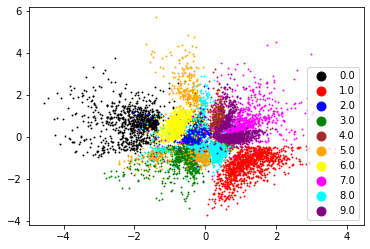

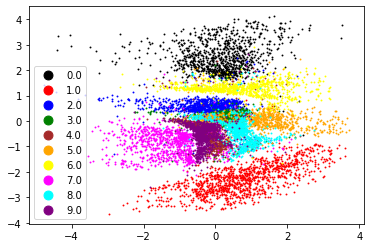

In [14]:
plot_latent_space(vae)
plot_latent_space(B_vae)

### Reconstruction

<ipython-input-22-e8b13c7deaae>:45: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


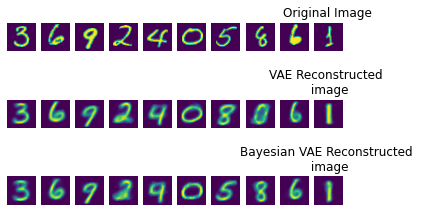

In [22]:
# Compare reconstructed images
img, _ = list(test_loader)[random.randint(0,20)]

with torch.no_grad():
    out_1, _, _ = vae(img.to(device))
    out_2, _, _, _ = B_vae(img.to(device))

img = img.reshape(-1, 784) # Reshaping into 1d vector
out_1 = out_1.cpu()
out_2 = out_2.cpu()
counter = 1

# Plotting original images
# Plotting first 10 images
for idx in range(10):
    val = img
    plt.subplot(3, 10, counter)
    plt.imshow(val[idx].reshape(28, 28))
    plt.axis('off')
  
    # Incrementing subplot counter
    counter += 1
plt.title("Original Image")
# Plotting first 10 images of the batch
for idx in range(10):
    val = out_1
    plt.subplot(3, 10, counter)
    plt.imshow(val[idx].reshape(28, 28))
    plt.axis('off')
  
    # Incrementing subplot counter
    counter += 1
plt.title("VAE Reconstructed \n image")

for idx in range(10):
    val = out_2
    plt.subplot(3, 10, counter)
    plt.imshow(val[idx].reshape(28, 28))
    plt.axis('off')
  
    # Incrementing subplot counter
    counter += 1
plt.title("Bayesian VAE Reconstructed \n image")

plt.tight_layout()
plt.savefig("Visualization.png")
plt.show()

In [24]:
# test reconstruction loss
with torch.no_grad(): 
    for model in [vae, B_vae]:
        model.eval()
        test_loss = 0
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_x = model(data)[0]
            test_loss += F.mse_loss(recon_x, data.view(-1, 784), reduction='sum').item()
          
        test_loss /= len(test_loader.dataset)
        print('{} Test set reconstrcution loss: {:.4f}'.format(model._get_name(), test_loss))

VAE Test set reconstrcution loss: 28.0897
Baysian_VAE Test set reconstrcution loss: 29.4966


### Calculate likelihood

In [15]:
# using Importance Sampling Estimator
# using encoder as the q distribution
sample_N = 10
p_x_lis = []
with torch.no_grad():
    for data, _ in test_loader:
        data = data.to(device)
        data = torch.where(data > 0.5, 1.0, 0.0)  # keep the same setting as using pyro

        mu, logvar = vae.encode(data)   # batch_size, 2
        q_distribution = t_dist.normal.Normal(mu, (logvar * 0.5).exp())
        z_sample = q_distribution.sample(torch.Size([sample_N])).to(device) # n, batch_size,  2

        q_z = q_distribution.log_prob(z_sample).sum(dim=2)  # n, batch_size

        p_z = t_dist.normal.Normal(torch.tensor(0,).to(device), torch.tensor(1,).to(device)).log_prob(z_sample).sum(dim=2) # n, batch_size
        
        Bernoulli_p = vae.decode(z_sample.view(-1, 2)).view(sample_N, -1, 1, 28, 28 )  # n, batch_size, 1, 28, 28
        p_x_given_z = -1 * F.binary_cross_entropy(Bernoulli_p, \
            data.unsqueeze(0).expand(sample_N, -1, -1, -1, -1), reduction='none').sum(dim=(-3,-2,-1)) # n, batch_size

        p_x = torch.logsumexp(p_x_given_z + p_z - q_z, dim=0) - torch.log(torch.tensor(sample_N, device=device))
        p_x_lis.append(p_x)

        # if random.random() < 0.1:
        #   output_lis = [p_x_given_z, p_z, q_z]
        #   print([item.mean().item() for item in output_lis])

    mean_log_p_x = torch.cat(p_x_lis, dim=0).mean()
    print(vae._get_name(), mean_log_p_x)

VAE tensor(-131.6107, device='cuda:0')


do again with pyro

In [16]:


def model(obs):
    with pyro.plate("data", obs.shape[0]):
        # setup hyperparameters for prior p(z)
        z_mu = obs.new_zeros(torch.Size((obs.shape[0], 2)))
        z_logvar = obs.new_zeros(torch.Size((obs.shape[0], 2)))
        # sample from prior (value will be sampled by guide when computing the ELBO)
        z = pyro.sample("z", p_dist.Normal(z_mu, (z_logvar*0.5).exp()).to_event(1))
        
        Bernoulli_p = vae.decode(z)
        
        pyro.sample("x", p_dist.Bernoulli(Bernoulli_p).to_event(1), obs=obs.view(-1, 784))

def guide(x):
    with pyro.plate("data", x.shape[0]):
        # use the encoder to get the parameters used to define q(z|x)
        z_mu, z_logvar = vae.encode(x)
        
        pyro.sample("z", p_dist.Normal(z_mu, (z_logvar*0.5).exp()).to_event(1))

importance = Importance(model, guide=guide, num_samples=100)

with torch.no_grad():
    # we have to make data binary to use Bernoulli distribution
    data = torch.where(test_loader.dataset.data > 0.5, 1.0, 0.0).to(device)
    importance.run(data)
print(importance.get_ESS())
print(vae._get_name(),importance.get_log_normalizer() / data.size(0))


tensor(1.)
VAE tensor(-164.2487)


We can use Importance Sampling Esitmator, because we have very good $q(z,\theta)$, i.e., close to posterior $p(z,\theta|x)$
since we assume $z$ and $\theta$ are independent, $q(z,\theta) = q(z) q(\theta)$, where $q(z)$ is given by encoder, $q(\theta)$ is stored in the decoder.

In [17]:
# using Importance Sampling Estimator
# using encoder as the q distribution
sample_N = 10
p_x_lis = []
with torch.no_grad():
    for data, _ in test_loader:
        data = data.to(device)
        data = torch.where(data > 0.5, 1.0, 0.0)  # keep the same as when using pyro 

        mu, logvar = B_vae.encode(data)   # batch_size, 2
        q_z_distribution = t_dist.normal.Normal(mu, (logvar * 0.5).exp())
        z_sample = q_z_distribution.sample(torch.Size([sample_N])).to(device) # n, batch_size,  2

        q_z = q_z_distribution.log_prob(z_sample).sum(dim=2)  # n, batch_size

        theta_sample = []
        q_theta = []
        for layer in [B_vae.fc3, B_vae.fc3a, B_vae.fc4]:
            # sample w and b from distribution
            q_w_distribution = t_dist.normal.Normal(layer['w_mean'], (layer['w_logvar'] * 0.5).exp())   # in_dim, out_dim
            q_b_distribution = t_dist.normal.Normal(layer['b_mean'], (layer['b_logvar'] * 0.5).exp())   # out_dim
            weights_w = q_w_distribution.sample(torch.Size([sample_N])).to(device)  # n, in_dim, out_dim
            weights_b = q_b_distribution.sample(torch.Size([sample_N])).to(device)  # n, out_dim

            # print(weights_w.size())
            # print(q_w_distribution.log_prob(weights_w))
            # print(q_w_distribution.log_prob(weights_w).sum(dim=(1,2)))

            theta_sample.append({'weights_w': weights_w, 'weights_b': weights_b})
            q_theta.append(q_w_distribution.log_prob(weights_w).sum(dim=(1,2)) + q_b_distribution.log_prob(weights_b).sum(dim=1))   # n,
        q_theta = torch.stack(q_theta).sum(dim=0) # n,


        p_z = t_dist.normal.Normal(torch.tensor(0,).to(device), torch.tensor(1,).to(device)).log_prob(z_sample).sum(dim=2) # n, batch_size
        
        p_theta = []
        for weights in theta_sample:
            k = weights['weights_w'].size(1)
            theta_prior = t_dist.normal.Normal(torch.tensor(0,).to(device), torch.tensor(k**(-0.5),).to(device))
            p_theta.append(theta_prior.log_prob(weights['weights_w']).sum(dim=(1,2)) + \
                            theta_prior.log_prob(weights['weights_b']).sum(dim=1))
            
        p_theta = torch.stack(p_theta).sum(dim=0)   # n,   

        Bernoulli_p = B_vae.decode(z_sample, theta_sample).view(sample_N, -1, 1, 28, 28 )  # n, batch_size, 1, 28, 28
        p_x_given_z_theta = -1 * F.binary_cross_entropy(Bernoulli_p, \
            data.unsqueeze(0).expand(sample_N, -1, -1, -1, -1), reduction='none').sum(dim=(-3,-2,-1)) # n, batch_size

        p_x = torch.logsumexp(p_x_given_z_theta + p_z + p_theta.unsqueeze(1) - q_z - q_theta.unsqueeze(1), dim=0) - \
                torch.log(torch.tensor(sample_N, device=device))
        p_x_lis.append(p_x)

        # if random.random() < 0.1:
        #   output_lis = [p_x_given_z_theta, p_z , p_theta , q_z , q_theta]
        #   print([item.mean().item() for item in output_lis])

    mean_log_p_x = torch.cat(p_x_lis, dim=0).mean()
    print(B_vae._get_name(), mean_log_p_x)

Baysian_VAE tensor(-214545.8438, device='cuda:0')


In [18]:

def model(obs):
    theta = []
    for layer, name in zip([B_vae.fc3, B_vae.fc3a, B_vae.fc4], ['fc3','fc3a','fc4']):
        k = layer['w_mean'].size(0)
        weights_w = pyro.sample("%s_w"%name, p_dist.Normal(obs.new_zeros(layer['w_mean'].size()), \
                        obs.new_ones(layer['w_logvar'].size()) * k**(-0.5) ).to_event(2))
        weights_b = pyro.sample("%s_b"%name, p_dist.Normal(obs.new_zeros(layer['b_mean'].size()), \
                        obs.new_ones(layer['b_logvar'].size()) * k**(-0.5) ).to_event(1))
        theta.append({'weights_w': weights_w, 'weights_b': weights_b})
    
    with pyro.plate("data", obs.shape[0]):
        # setup hyperparameters for prior p(z)
        z_mu = obs.new_zeros(torch.Size((obs.shape[0], 2)))
        z_logvar = obs.new_zeros(torch.Size((obs.shape[0], 2)))
        # sample from prior (value will be sampled by guide when computing the ELBO)
        z = pyro.sample("z", p_dist.Normal(z_mu, (z_logvar*0.5).exp()).to_event(1))

        Bernoulli_p = B_vae.decode(z, theta)
        
        pyro.sample("x", p_dist.Bernoulli(Bernoulli_p).to_event(1), obs=obs.view(-1, 784))


def guide(x):

    for layer, name in zip([B_vae.fc3, B_vae.fc3a, B_vae.fc4], ['fc3','fc3a','fc4']):
        pyro.sample("%s_w"%name, p_dist.Normal(layer['w_mean'], (layer['w_logvar'] * 0.5).exp()).to_event(2))
        pyro.sample("%s_b"%name, p_dist.Normal(layer['b_mean'], (layer['b_logvar'] * 0.5).exp()).to_event(1))
        
    with pyro.plate("data", x.shape[0]):
        # use the encoder to get the parameters used to define q(z|x)
        z_mu, z_logvar = B_vae.encode(x)
        
        pyro.sample("z", p_dist.Normal(z_mu, (z_logvar*0.5).exp()).to_event(1))

pyro.clear_param_store()
torch.cuda.empty_cache()
importance = Importance(model, guide=guide, num_samples=100)


with torch.no_grad():
    # we have to make data binary to use Bernoulli distribution
    data = torch.where(test_loader.dataset.data > 0.5, 1.0, 0.0).to(device)
    importance.run(data)
print(importance.get_ESS())
print(B_vae._get_name(), importance.get_log_normalizer() / data.size(0))


tensor(1.)
Baysian_VAE tensor(-189.7890)
